<a href="https://colab.research.google.com/github/mathurinjpp-dot/tp_segmentation1/blob/tp_cnn/3_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation TP
Now, you have the basis to implement a training optimization loop for a classification model. In this module, your task will be to implement a model architecture for semantic segmentation. For this TP, we will use the PascalVOC 2012 Semantic Segmentation dataset.

Before training any model, we need to load the data.

In [ ]:
# import all libraries
import os
import os.path as osp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.utils.data as data

%matplotlib inline

In [ ]:
if not osp.exists('pascal-features.zip'):
    !wget -O pascal-features.zip "https://huggingface.co/datasets/loiximon/pascal-features-dllabs/resolve/main/pascal-features.zip?download=true"
    !unzip -q pascal-features.zip
else:
    print('You already downloaded the dataset :)')

You already downloaded the dataset :)


In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]]
VOC_COLORMAP = [[v[0] / 255, v[1] / 255, v[2] / 255, 1.0] for v in VOC_COLORMAP]
VOC_COLORMAP += [[0.0, 0.0, 0.0, 1.0]] * (255 - len(VOC_COLORMAP))
cmap = mpl.colors.ListedColormap(VOC_COLORMAP)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class PascalLoader():
    def __init__(self,
                 root,
                 train,
                 transform=None,
                 category=-1):
        self.root = root
        self.partition = 'train' if train else 'val'
        self.transform = transform
        self.change_category(category)

    def change_category(self, category):
        self.category = category
        if category == -1:
            self.data = os.listdir(osp.join(self.root, self.partition))
            return

        df = pd.read_csv(self.partition + '_instances.csv')
        names = df[df.iloc[:, category]]['filename']
        self.data = list(names)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.data[idx]
        dict_ = torch.load(osp.join(self.root, self.partition, name),weights_only=True)
        img = dict_['image']
        features = dict_['feature'].to(dtype=torch.float)
        min_, max_ = dict_['min'], dict_['max']
        features = features * (max_ - min_) + min_
        label = dict_['label']
        if self.transform is not None:
            img, features, label = self.transform(img, features, label)

        if self.category != -1:
            label = (label == self.category).to(dtype=torch.uint8)
        return img, features, label

With the functions `show_image` and `show_label` you can visualize both image and label. So, let's visualize some examples from the dataset!
By the way, don't worry about the weird colors in the segmentation map, it is due to a compression issue. As a reminder, you will not be able to visualize the precomputed feature maps. Note as well that the images of the dataset are different size!

In [ ]:
@torch.no_grad()
def show_image(img):
    '''
    Visualize a torch object respresenting an image. The tensor must have shape [H, W, 3] and each pixel are in the [0, 1] range
    '''
    img = img.cpu().numpy()
    plt.imshow(img, vmin=0, vmax=255)


@torch.no_grad()
def show_pred(pred):
    '''
    Visualize a tensor prediction of shape [H, W], each value should be an integer value between 0 and 255.
    '''
    pred = pred.cpu().float().numpy() / 255
    plt.imshow(pred, cmap=cmap, vmin=0.0, vmax=1.0)


@torch.no_grad()
def show_image_and_label(img, label):
    plt.subplot(1, 2, 1)
    show_image(img)
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1, 2, 2)
    show_pred(label)
    plt.title('Label')
    plt.axis('off')


@torch.no_grad()
def show_image_pred_gt(img, pred, label):
    plt.subplot(1, 3, 1)
    show_image(img)
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1, 3, 2)
    show_pred(pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    show_pred(label)
    plt.title('Label')
    plt.axis('off')


training_set = PascalLoader(root='pascal-features', train=True)

Image 1 Size: torch.Size([256, 320, 3])
Image 2 Size: torch.Size([384, 256, 3])
Image 3 Size: torch.Size([256, 512, 3])


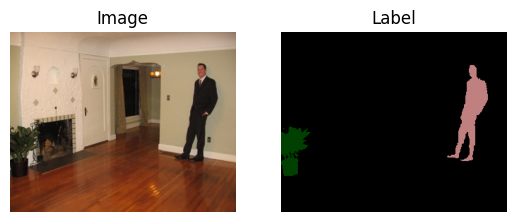

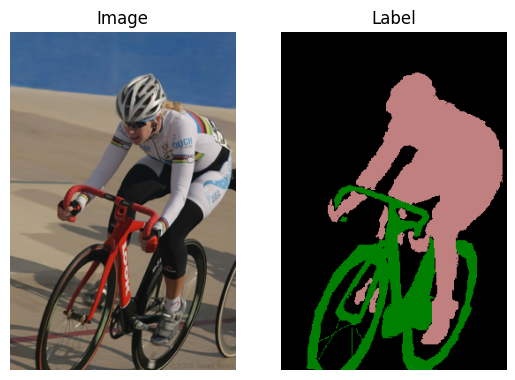

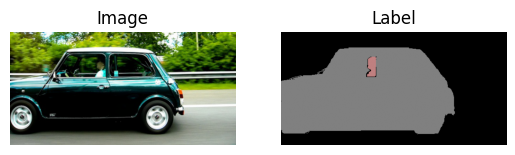

In [ ]:
img, _, label = training_set[234]
show_image_and_label(img, label)
print('Image 1 Size:', img.shape)
f = plt.figure()
img, _, label = training_set[0]
show_image_and_label(img, label)
print('Image 2 Size:', img.shape)
f = plt.figure()
img, _, label = training_set[1000]
show_image_and_label(img, label)
print('Image 3 Size:', img.shape)

Further, we can change the dataset to only give use the images with a specific object class (_e.g._ category 8 is class cat). Please note that by changing the category, the label will only give that class as the target segmentation map!

Image 1 Size: torch.Size([256, 416, 3])
Image 2 Size: torch.Size([256, 320, 3])


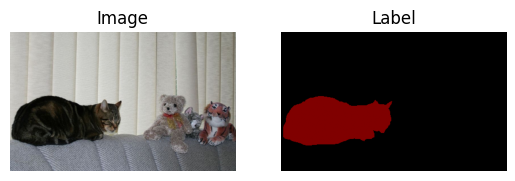

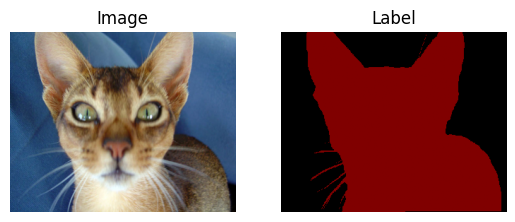

In [ ]:
training_set.change_category(8)
img, _, label = training_set[10]
show_image_and_label(img, label)
print('Image 1 Size:', img.shape)
plt.figure()
img, _, label = training_set[59]
show_image_and_label(img, label)
print('Image 2 Size:', img.shape)


## Exercise

Given the data set, your next task is to train a DNN to segment cats! This network uses the precomputed features from an unknown network, does some operations to produce the segmentation map. By the way, don't worry, the features are extracted from the image in the tuple. To achieve this, you need to the following steps:


1) Create a new function called `transform` to extract a center crop (size 224x224) from the image, the features, and the target. Also, the image and the feature map should _permute_ their axis from `(H, W, C)` to `(C, H, W)`. Further, visualize the image before and after the transformation to visually check that both crop was correctly performed.

[Ok]


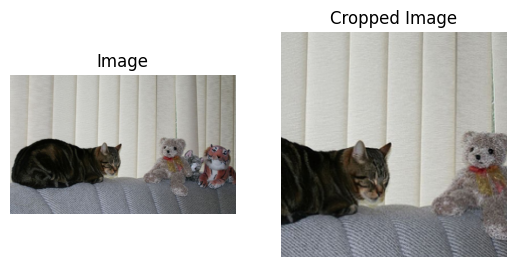

In [ ]:
import torchvision.transforms as transforms

def transform(img, feature, label):
    img = img.permute(2, 0, 1)
    feature = feature.permute(2, 0, 1)
    crop = transforms.CenterCrop(224)
    img = crop(img)
    feature = crop(feature)
    return img, feature, label

def exercise_transform():
    img, feature, label = training_set[10]
    img2, feature2, label2 = transform(img, feature, label)

    if img2.shape == (3, 224, 224) and feature2.shape == (64, 224, 224):
        print('[Ok]')
        plt.subplot(1, 2, 1)
        show_image(img)
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img2.permute(1, 2, 0))
        plt.title('Cropped Image')
        plt.axis('off')
    else:
        print('[Not OK] Image or Feature shapes are incorrect. Expected image shape {} but got {}. Expected feature shape {} but got {}'.format((3, 224, 224),img2.shape, (64, 224, 224), feature2.shape))

exercise_transform()


2) Create the dataset (including your `transform`) and the dataloader for the optimization and evaluation loop.

In [ ]:
training_set = PascalLoader(root='pascal-features',
                            train=True,
                            transform=transform,
                            category=8)
train_loader = data.DataLoader(training_set,
                               num_workers=2,
                               batch_size=16,
                               shuffle=True)

val_set = PascalLoader(root='pascal-features',
                       train=False,
                       transform=transform,
                       category=8)
val_loader = data.DataLoader(val_set,
                             num_workers=2,
                             batch_size=16,
                             shuffle=False)

3. load your model, SGD optimizer with learning rate of $1e-5$, and loss function.

Create a new class `FCNN` wchich creates a fully convolutional neural network architecture using the nn.Module class to instantiate it. The input for this network is a tensor $f\in \mathbb{R}^{(H\times W\times 64)}$ and should output a tensor $O\in \mathbb{R}^{(H\times W\times 2)}$. Since it is fully convolutional, it should by (quasi) invariant to the input size.

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B,128,H,W]
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # [B,64,H,W]
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1)                # [B,2,H,W]
        )



    def forward(self, x):
        return self.model(x)

# TODO: Create your model, optimizer and loss function (dubbed criterion)
model = FCNN().to(device)
optimizer = 0
criterion = 0

NameError: name 'n_c' is not defined

4. Create the optimization loop for one epoch

In [ ]:
def epoch_optimization(model, device, criterion, optimizer, loader):

    model.train()
    running_loss = 0
    n = 0

    for _, feat, label in loader:
        feat = feat.to(device)
        label = label.to(device, dtype=torch.long)

        # TODO: optimization

        n += 1
        running_loss += loss.item()

    running_loss /= n
    return running_loss


5. Create your validation loop

In [ ]:
@torch.no_grad()
def epoch_validation(model, device, criterion, loader):

    model.eval()
    running_loss = 0
    n = 0

    for _, feat, label in loader:
        feat = feat.to(device)
        label = label.to(device, dtype=torch.long)

        # TODO: Validate the loss. There is no optimization

        n += 1
        running_loss += loss.item()

    running_loss /= n
    return running_loss

6. Train your model and plot the training and validation loss curves! Check that the training loss is decreasing at each epoch.

In [ ]:
# TODO: use your epoch_optimization and epoch_validation functions to train and assess the performance of your model. Train for as many epochs as you want

7. Create a new function `get_prediction` to extract the prediction of a single example and visualize some of your segmentations. Your function should receive as input a tensor $d\in \mathbb{R}^{1 \times 2 \times H \times W}$ and output the prediction $d \in \{0, 1\}^{H \times W}$. Here $H$ and $W$ can be any number. Here we use $H$ and $W$ can be any number.

In [ ]:
def get_prediction(pred):
    # TODO: compute your prediction
    return torch.zeros(1)


def exercise_prediction():
    a = torch.rand(1, 1, 5, 4) / 2
    b = torch.rand_like(a) / 2 + 1
    o1 = torch.cat([a, b], dim=1)
    o2 = torch.cat([b, a], dim=1)
    output = torch.cat([o1, o2], dim=2)
    target = torch.zeros(10, 4, dtype=torch.int)
    target[:5] = 1
    pred = get_prediction(output).to(dtype=torch.int)
    if torch.all(pred == target):
        print('[OK]')
    else:
        print('[Not OK] Expected predition to be')
        print(target)
        print('but got')
        print(pred)

exercise_prediction()

In [ ]:
img, feat, label = training_set[59]
img = img.permute(1, 2, 0)
out = model(feat.unsqueeze(0).to(device))
pred = get_prediction(out)
show_image_pred_gt(img, pred, label)


In [ ]:
img, feat, label = training_set[10]
img = img.permute(1, 2, 0)
out = model(feat.unsqueeze(0).to(device))
pred = get_prediction(out)
show_image_pred_gt(img, pred, label)

In [ ]:
img, feat, label = val_set[51]
img = img.permute(1, 2, 0)
out = model(feat.unsqueeze(0).to(device))
pred = get_prediction(out)
show_image_pred_gt(img, pred, label)

8. Time to evaluate your model. Semantic segmentation is traditionally assessed with the Jaccard Index, also referred to as Intersection over Union (IoU). Given the ground truth $Y^{GT}$ and the prediction $P$, the IoU is computed as follows: $$IoU(Y^{GT}, P) = \frac{|Y^{GT} \cap P|}{|Y^{GT} \cup P|}$$ In practice, we need simply compute the ratio between the amount of pixels that were correctly predicted as the target class (thus, the intersection) against the number of pixels that are predicted as the target class or correspond to the label mask (union).
   Now, you need to create a function `compute_iou` to compute the jaccard index between a prediction and its corresponding label, both in $\{0, 1\}^{H, W}$. Its inputs are a prediction and a label, both with the same shape and should produce a torch float.

In [ ]:
def compute_iou(pred, label):
    # TODO: compute the IoU
    iou = torch.tensor(0.0)
    return iou


def exercise_iou():
    _, _, label1 = training_set[10]
    _, _, label2 = training_set[11]
    iou = compute_iou(label1, label2)
    target = torch.tensor(0.14842958748340607)
    if torch.isclose(iou.cpu(), target):
        print('[OK]')
    else:
        print('[Not OK] Excepted {} but got {}'.format(target, iou))

exercise_iou()

9. Extract the mean IoU for all the training and validation set. To do so, create or adapt your `transform` function to not perform the center crop. Create another function `evaluate` to assess your model. Then, run through all the training and validation set to extract their corresponding mean IoU. Finally, perform the evaluation with your same model without any training, _e.i._ with random weights.

In [ ]:
def new_transform(img, feature, label):
    # TODO
    return img, feature, label

training_set = PascalLoader(root='pascal-features',
                            train=True,
                            transform=new_transform,
                            category=8)
train_loader = data.DataLoader(training_set,
                               num_workers=2,
                               batch_size=1,
                               shuffle=True)

val_set = PascalLoader(root='pascal-features',
                       train=False,
                       transform=new_transform,
                       category=8)
val_loader = data.DataLoader(val_set,
                             num_workers=2,
                             batch_size=1,
                             shuffle=False)
@torch.no_grad()
def evaluate(model, loader, device):
    # TODO: Compute the IoU for all images.
    miou = 0
    return miou


def exercise_iou():
    random_model = FCNN().to(device)
    random_model.eval()

    train_iou_random = evaluate(random_model, train_loader, device)
    train_iou = evaluate(model, train_loader, device)

    val_iou_random = evaluate(random_model, val_loader, device)
    val_iou = evaluate(model, val_loader, device)

    print('[Trained Model performance] Training {} | Validation {}'.format(train_iou, val_iou))
    print('[Random  Model performance] Training {} | Validation {}'.format(train_iou_random, val_iou_random))


exercise_iou()


### Questions:
* Why do we need to compute a center crop for the training?
* Why we set a batch size of 1 for evaluation?
* What is a fully convolutional neural network?
* For the single-class segmentation, why the output has two channels? Could you implement it with a single output channel?


# Homework

In this homework, you will implement new configurations for semantic segmentation. We expect you to discuss your findings and results, even when they are negative. There will be several tasks, but, you don't need to finish them all. Be careful and don't rush to complete everything. _Remember that quality $>$ quantity_. Even though you can do as many as you want, we expect good-quality results and discussions. For every exercise explain your experiment, show your results in a table, and describe your results. Here's a little example:

>In the following experiment, we test if using the Mean Square Error (MSE), the Binary Cross Entropy (BCE), or a combination of both helps the segmenter reach a better Intersection over Union (IoU). In this experiment, we expect that the combination of losses outperforms each individual one.
>
> |Loss  |IoU  |
> |------|-----|
> |MSE   | 0.45|
> |BCE   | 0.37|
> |MSE+BCE|0.42|
>
> Our experiment shows that using the MSE performs better than using the BCE alone. To our surprise, mixing both loss functions decreases the IoU. We believe that the BCE reaches a local minimum with a higher loss than the MSE. Thus, it pulls the MSE toward a less-performing region on the parameter space.



Choose carefully which tasks to do, but most importantly, have fun! Now, you have to choose a new category to segment differently from cat. By the way, these are the classes: `0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor`.

These are the tasks you can solve:
* Implement a single output channel FCNN and compare it with the bi-channeled FCNN created in the TP. You can train it with several loss functions: Mean Square Error, Binary Cross Entropy, Dice Loss, or a combination of those losses
* Add a dynamic or static weight to the loss.
* Add a data augmentation technique.
* Train a multicategory segmenter and code the performance evaluation.
* Explore other optimizers and add weight decay.
* Implement the Exponential Moving Average.
* Explore other architectures for your FCNN.
* Create a network to process the image instead of the feature map. _Important Note_: This one will take too much time and resources, we don't recommend it.